# Visualize the results on practical PIV recordings
- Solid-body rotation in Exp5-1, and homography transformation in Exp5-2

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# PIV method
from pig import AttrDict
from deformpiv import DeformPIV

from fdi2cdi import fdi2cdi
from metrics import PIVmetric, EPE 

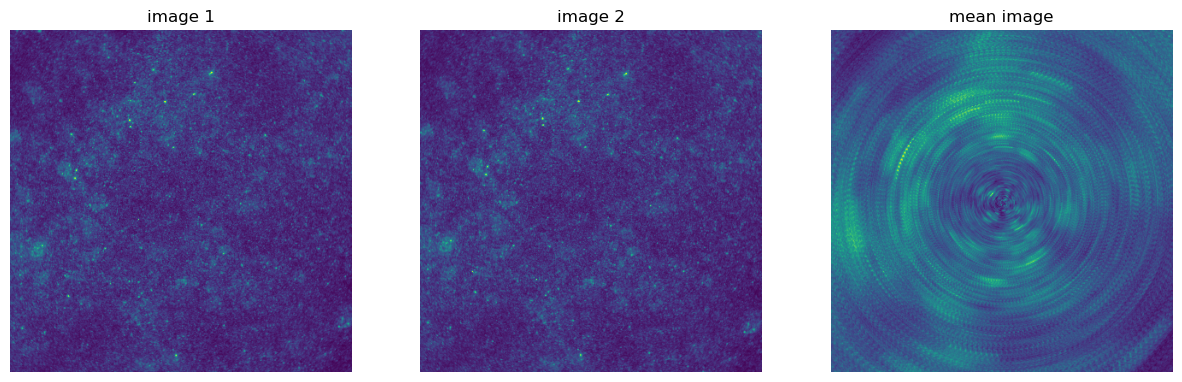

In [2]:
# Read all data 
# path = "/media/newdisk/datasets_piv/yong_solid_rotation/real_case1"
path = "./TestImages/real_case1"
names = os.listdir(path)
names.sort()

imgs = [cv2.imread(os.path.join(path,n),0)[312:712,571:971] for n in names]
# imgs = [cv2.imread(os.path.join(path,n),0)[212:612,571:1071] for n in names]

# show the images
data = np.array(imgs)
img_mean = np.mean(data, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(131); plt.title("image 1")
plt.imshow(imgs[0]); plt.axis("off")
plt.subplot(132); plt.title("image 2")
plt.imshow(imgs[1]); plt.axis("off")
plt.subplot(133); plt.title("mean image")
plt.imshow(img_mean); plt.axis("off")

plt.show()

In [3]:
# Find out the Transform with cv2.findTransformECC()
def Transform(img1, img2):
    # Find size of image1
    sz = img1.shape
    
    # Define the motion model: can be TRANSLATION OR AFFINE OR HOMOGRAPHY
    warp_mode = cv2.MOTION_EUCLIDEAN
    
    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)
    
    # Specify the number of iterations.
    number_of_iterations = 5000;
    
    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps = 1e-10;
    
    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    
    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC(img1, img2, warp_matrix, warp_mode, criteria)
    return warp_matrix

def matrix_extract(warp_matrix):
    # the angular
    omega = np.arctan2(warp_matrix[0,1], warp_matrix[0,0])
    omega_deg = omega*180/np.pi
    
    W = np.zeros([3,3])
    W[:2,:] = warp_matrix
    W[2,2] = 1.0
    eigenvalues, eigenvectors = np.linalg.eig(W)
    center_point = np.real(eigenvectors[:,2]/eigenvectors[2,2])
    # print(eigenvalues)
    # print(eigenvectors[:,2]/eigenvectors[2,2])
    return omega, omega_deg, center_point
    
warp_matrix = Transform(imgs[0],imgs[1]) # The matrix reflects the image deformation
omega, omega_deg, cp = matrix_extract(warp_matrix)
print(f"The rotation angle is -2.0000 deg [33.3333r/min, 0.01s], the measured {omega_deg:.4f} deg")
print(f"The center point is ({cp[0]:.3f},{cp[1]:.3f}) in pixel")

The rotation angle is -2.0000 deg [33.3333r/min, 0.01s], the measured -2.0054 deg
The center point is (200.251,200.535) in pixel


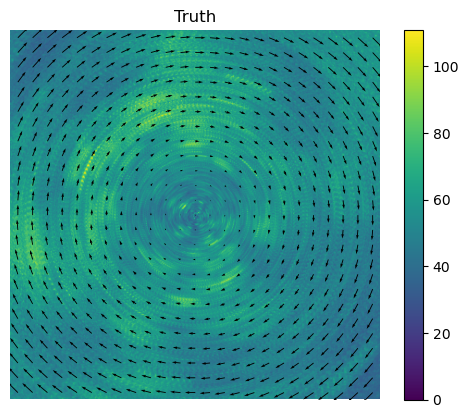

In [4]:
# construct the ground truth for PIV evaluation
def flow_truth(sz, omega, cp):
    x, y = np.meshgrid(np.arange(sz[0]), np.arange(sz[1]),indexing="ij")
    x_, y_ = x-cp[1], y-cp[0]
    theta  = np.arctan2(x_, y_)
    r = np.sqrt(np.square(x_)+np.square(y_))
    V = r*omega
    u, v = -V*np.cos(theta), V*np.sin(theta)
    return x, y, u, v


def plot_vectors(epe, u, v, vmin=0, vmax=0.1):
    x, y = np.meshgrid(np.arange(u.shape[0]), np.arange(u.shape[1]), indexing='ij')

    plt.imshow(epe, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.quiver(x[8::16,8::16],y[8::16,8::16],-u[8::16,8::16],v[8::16,8::16])
    plt.axis('off')


x_t, y_t, u_t, v_t = flow_truth(imgs[0].shape, omega, cp)

plt.figure()
plot_vectors(img_mean, u_t, v_t, vmax=None)
plt.title("Truth")
plt.show()

In [5]:
# perform PIV analysis with OF
config = AttrDict()
config.pivmethod = 'opticalflow' # ['crosscorrelation', 'opticalflow', 'raft_estimator']
config.runs = 6

config.deform = 'FDI' # ['FDI', 'CDI', 'CDDI', 'FDDI']
piv = DeformPIV(config)
x_fdi, y_fdi, u_fdi, v_fdi = piv.compute(imgs[0], imgs[1])

config.deform = 'CDI' # ['FDI', 'CDI', 'CDDI', 'FDDI']
piv = DeformPIV(config)
x_cdi, y_cdi, u_cdi, v_cdi = piv.compute(imgs[0], imgs[1])

v_fdi2cdi,u_fdi2cdi = fdi2cdi(v_fdi, u_fdi, t=0, delta=1)

# Remove the boundary with width 25
u_fdi, v_fdi = u_fdi[25:-25,25:-25], v_fdi[25:-25,25:-25] 
u_cdi, v_cdi = u_cdi[25:-25,25:-25], v_cdi[25:-25,25:-25]
u_fdi2cdi, v_fdi2cdi = u_fdi2cdi[25:-25,25:-25], v_fdi2cdi[25:-25,25:-25]  
u_t, v_t =  u_t[25:-25,25:-25], v_t[25:-25,25:-25] 

epe_fdi = EPE(u_t, v_t, u_fdi, v_fdi)
epe_cdi = EPE(u_t, v_t, u_cdi, v_cdi)
epe_fdi2cdi = EPE(u_t, v_t, u_fdi2cdi, v_fdi2cdi)


print("FDI (OF):")
res1 = PIVmetric(u_t,v_t,u_fdi,v_fdi)

print("CDI (OF):")
res2 = PIVmetric(u_t,v_t,u_cdi,v_cdi)

print("FDI2CDI (OF):")
res3 = PIVmetric(u_t,v_t,u_fdi2cdi,v_fdi2cdi)

FDI (OF):
0.1126(RMSE)	0.1022(AEE)	0.0213(AAE,rad)	0.9910(SSIM)	1.0003(MoC)	0(Outlier)	
CDI (OF):
0.0910(RMSE)	0.0807(AEE)	0.0149(AAE,rad)	0.9927(SSIM)	1.0016(MoC)	0(Outlier)	
FDI2CDI (OF):
0.0738(RMSE)	0.0642(AEE)	0.0127(AAE,rad)	0.9937(SSIM)	1.0007(MoC)	0(Outlier)	


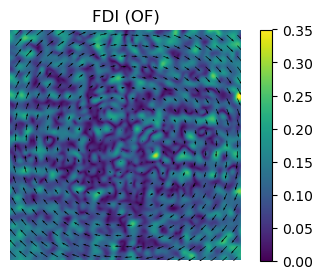

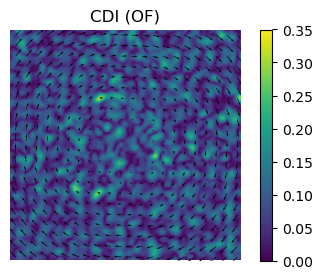

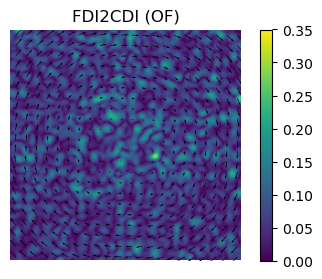

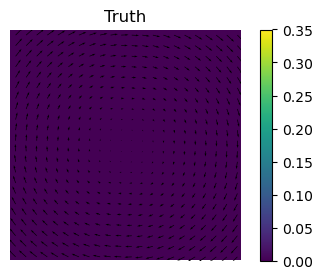

In [6]:
names = ["FDI (OF)", "CDI (OF)", "FDI2CDI (OF)", "Truth"]
epes = [epe_fdi, epe_cdi, epe_fdi2cdi, 0*epe_fdi2cdi]

for k, (u, v) in enumerate([(u_fdi, v_fdi),(u_cdi, v_cdi),(u_fdi2cdi, v_fdi2cdi),(u_t, v_t)]):
    plt.figure(figsize=(5,3))
    plot_vectors(epes[k], u, v, vmax=0.35)
    plt.savefig(f"output/Fig13_{names[k]}.pdf")
    plt.title(names[k])

plt.show()

In [7]:
# perform PIV analysis with CC
config = AttrDict()
config.pivmethod = 'crosscorrelation' # ['crosscorrelation', 'opticalflow', 'raft_estimator']
config.runs = 6

config.deform = 'FDI' # ['FDI', 'CDI', 'CDDI', 'FDDI']
piv = DeformPIV(config)
x_fdi, y_fdi, u_fdi, v_fdi = piv.compute(imgs[0], imgs[1])

config.deform = 'CDI' # ['FDI', 'CDI', 'CDDI', 'FDDI']
piv = DeformPIV(config)
x_cdi, y_cdi, u_cdi, v_cdi = piv.compute(imgs[0], imgs[1])

v_fdi2cdi,u_fdi2cdi = fdi2cdi(v_fdi, u_fdi, t=0, delta=1)

# Remove the boundary with width 25
u_fdi, v_fdi = u_fdi[25:-25,25:-25], v_fdi[25:-25,25:-25] 
u_cdi, v_cdi = u_cdi[25:-25,25:-25], v_cdi[25:-25,25:-25]
u_fdi2cdi, v_fdi2cdi = u_fdi2cdi[25:-25,25:-25], v_fdi2cdi[25:-25,25:-25]  

epe_fdi = EPE(u_t, v_t, u_fdi, v_fdi)
epe_cdi = EPE(u_t, v_t, u_cdi, v_cdi)
epe_fdi2cdi = EPE(u_t, v_t, u_fdi2cdi, v_fdi2cdi)


print("FDI (CC):")
res1 = PIVmetric(u_t,v_t,u_fdi,v_fdi)

print("CDI (CC):")
res2 = PIVmetric(u_t,v_t,u_cdi,v_cdi)

print("FDI2CDI (CC):")
res3 = PIVmetric(u_t,v_t,u_fdi2cdi,v_fdi2cdi)

FDI (CC):
0.1112(RMSE)	0.1014(AEE)	0.0207(AAE,rad)	0.9894(SSIM)	0.9993(MoC)	0(Outlier)	
CDI (CC):
0.0749(RMSE)	0.0642(AEE)	0.0121(AAE,rad)	0.9930(SSIM)	0.9998(MoC)	0(Outlier)	
FDI2CDI (CC):
0.0688(RMSE)	0.0591(AEE)	0.0110(AAE,rad)	0.9936(SSIM)	0.9997(MoC)	0(Outlier)	


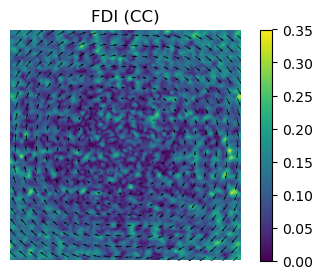

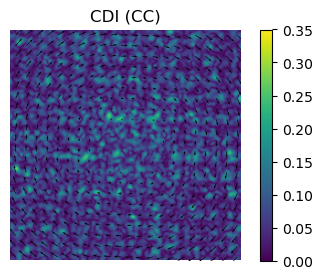

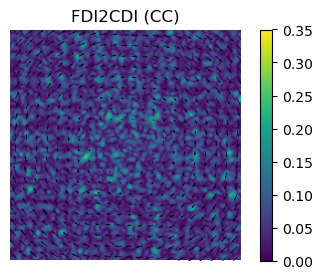

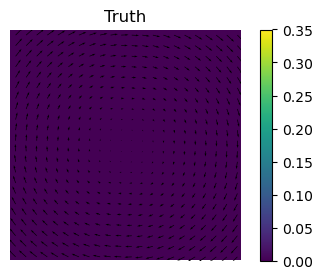

In [8]:
names = ["FDI (CC)", "CDI (CC)", "FDI2CDI (CC)", "Truth"]
epes = [epe_fdi, epe_cdi, epe_fdi2cdi, 0*epe_fdi2cdi]

for k, (u, v) in enumerate([(u_fdi, v_fdi),(u_cdi, v_cdi),(u_fdi2cdi, v_fdi2cdi),(u_t, v_t)]):
    plt.figure(figsize=(5,3))
    plot_vectors(epes[k], u, v, vmax=0.35)
    plt.savefig(f"output/Fig13_{names[k]}.pdf")
    plt.title(names[k])

plt.show()